# Lecture 21 - LINEAR DATA FITTING WITH UNCERTANTIES - HW 10

As scientists one of our many checks is to fit data to models.  Here, we will begin first by learning how to fit data with uncertanties to a linear fit (slope and intercept, and uncertanties) by using the python `scipy` module. 

In [46]:
#standard importing
from matplotlib import pyplot as plt
import numpy as np
import scipy.optimize as opt

In [47]:
#Read in the data to a numpy array
data = np.genfromtxt("LinearFit_data.txt", names=True, dtype=None)

# print out all columns we just got for free
data.dtype

dtype([('X', '<f8'), ('Y', '<f8'), ('Y_ERR', '<f8'), ('Z', '<f8'), ('Z_ERR', '<f8')])

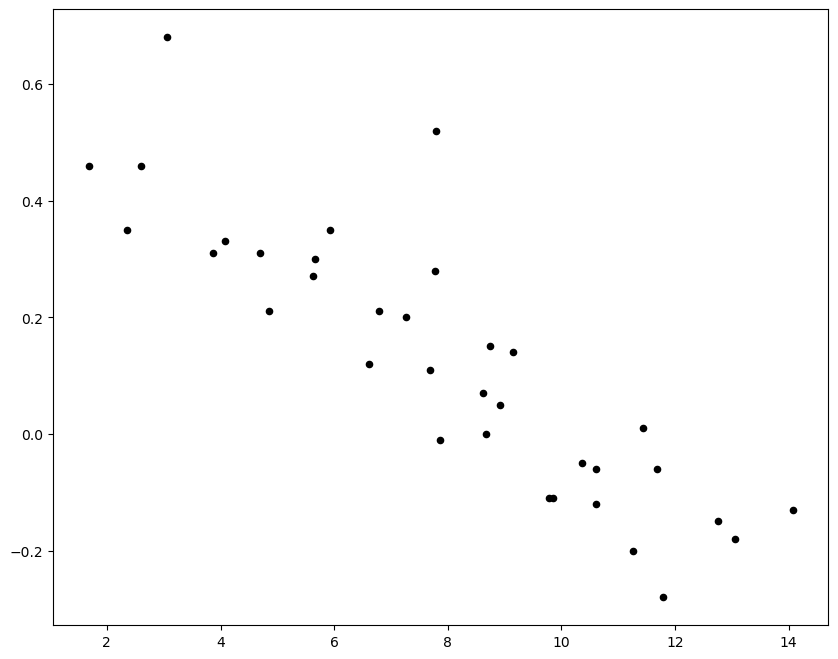

In [48]:
#First let's see what this data looks like
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Y'],s=20,c='black')

# Cool! The data actually looks pretty linear so we can assume the function we are fitting *is* linear

In [49]:
# let's make a linear function the normal way
def linear(x, m, b):
    return m * x + b

raw:  -0.061902193399352975 0.6174204495463552
raw:  [ 3.63943119e-05 -2.88586096e-04] [-0.00028859  0.0026655 ]


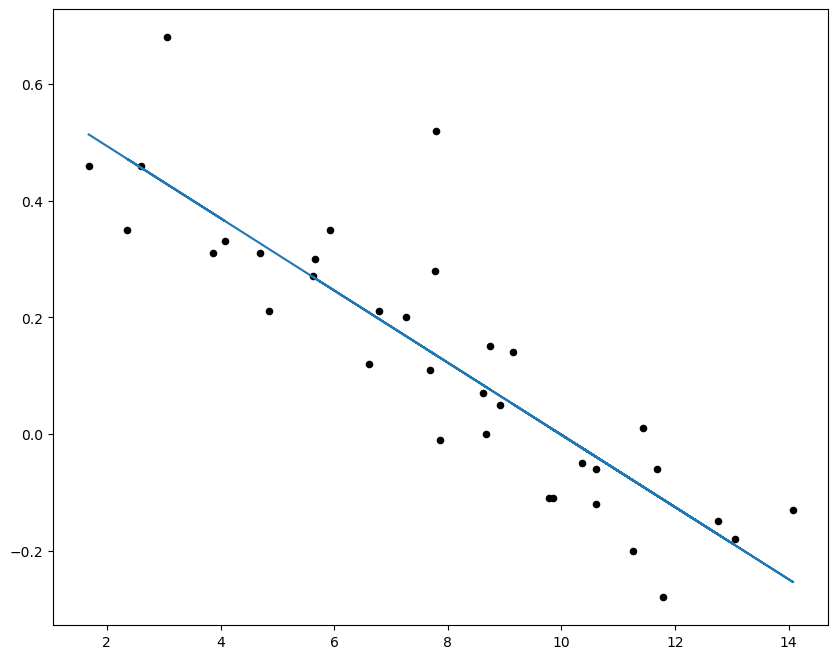

In [50]:
# let's do a linear fit to the data

popt, pcov = opt.curve_fit(linear, data['X'], data['Y'])
print("raw: ", *popt)
print("raw: ", *pcov)


fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Y'],s=20,c='black')
ax.plot(data['X'],linear(data['X'], *popt))


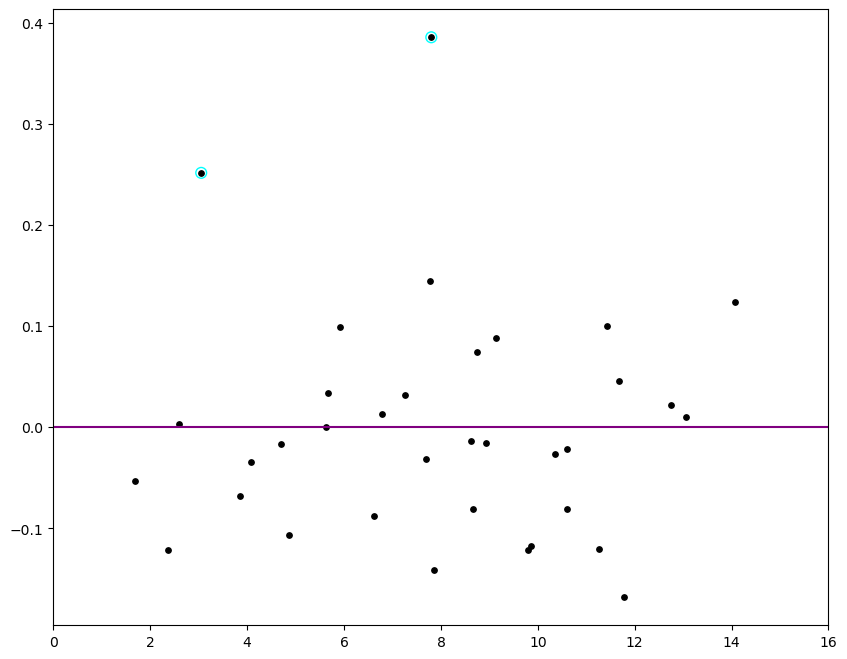

In [51]:
#Let's look into wich data are way off the fit.

residual = data['Y']-linear(data['X'],*popt)
x = np.linspace(0,20,1000)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.scatter(data['X'],residual,s=15,c='black')
ax.plot(x,x*0.0,color='purple')
ax.set_xlim(0,16)

outlier = np.absolute(residual)>0.20
ax.scatter(data['X'][outlier],residual[outlier],s=60,edgecolor='cyan',facecolor='none')


raw:  -0.061902193399352975 0.6174204495463552
outliers accounted for:  -0.0581318237215009 0.5703220759875326


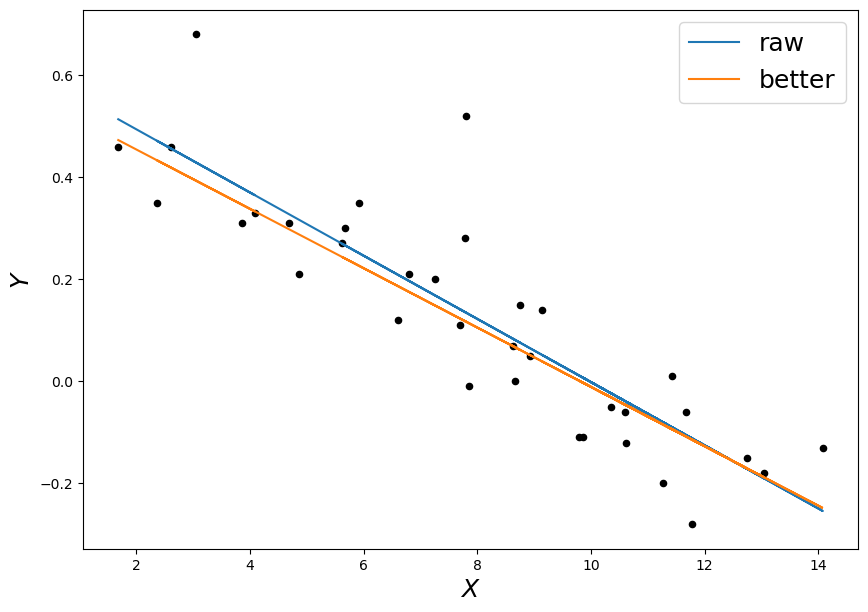

In [52]:
# our values for the raw data above:
# slope:    -0.058187
# intercept: 0.565351
popt, pcov = opt.curve_fit(linear, data['X'], data['Y'])
print("raw: ", *popt)

# we can use curve_fit to de-weight outliers automatically

# note, result is dependent on choice of loss function
# need to see method to trf in order to use least_squares instead of leastsq
popt_clean, pcov = opt.curve_fit(linear, data['X'], data['Y'], method='trf', 
                                 loss='arctan', f_scale=0.20)
print("outliers accounted for: ", *popt_clean)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Y'],s=20,c='black',zorder=2)
# cleaner error bars than last time, play around with the parameters
#ax.errorbar(data['X'],data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
#            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with our fits
ax.plot(data['X'],linear(data['X'], *popt), label='raw')
ax.plot(data['X'],linear(data['X'], *popt_clean), label='better')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

-0.056065582982940974 0.5500877321369341


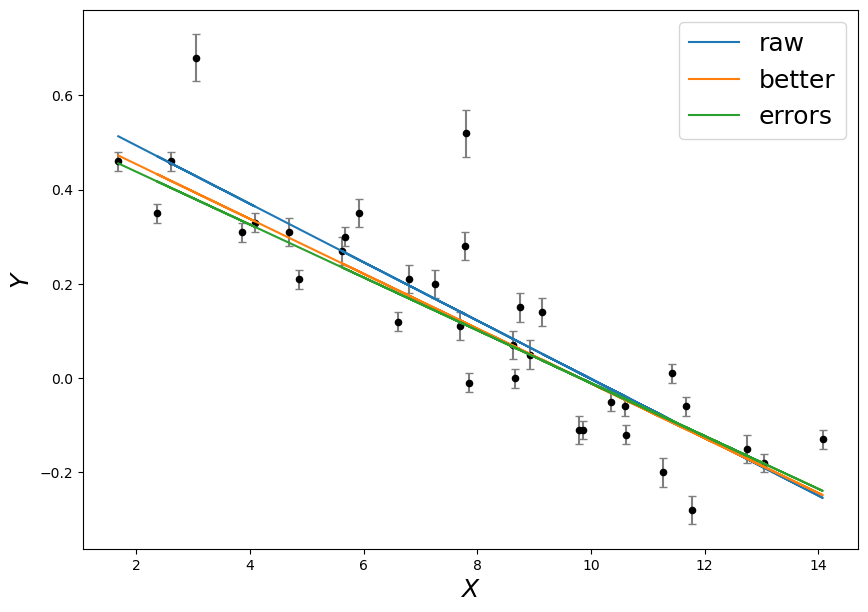

In [53]:
# lets account for the errors
# by pasing sigma, scipy knows to weight data according to their errors 
# naturally, sigma is expected to be the same size and correspond to y
# notice: this only accounts for y error
popt_err, pcov = opt.curve_fit(linear, data['X'], data['Y'], sigma=data['Y_ERR'])
print(*popt_err)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'],data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with out fits
ax.plot(data['X'],linear(data['X'], *popt), label='raw')
ax.plot(data['X'],linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'],linear(data['X'], *popt_err), label='errors')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

In [54]:
# Does this accurately explore the parameter space though?
# And what is the uncertainty on our data?
# What if we had x error bars?

# we'll explore a method utilizing the common "monte carlo" approach
def mcFit(x, y, x_err, y_err):
    slopes = list()
    y_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weights = np.random.randn(len(y))

        y_adj = y + y_err*weights
        x_adj = x  

        params, other = opt.curve_fit(linear, x_adj, y_adj)
        slopes.append(params[0])
        y_ints.append(params[1])
    
    return slopes, y_ints

slope, intercept = mcFit(data['X'], data['Y'],data['X_ERR'],data['Y_ERR'])

print('mean slope: {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope), np.mean(intercept)))

popt_err, pcov = opt.curve_fit(linear, data['X'], data['Y'], sigma=data['Y_ERR'])


fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with our fits
ax.plot(data['X'], linear(data['X'], *popt), label='raw')
ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='MC')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

ValueError: no field of name X_ERR

# Assistant
The error occurs because the code is trying to access a field named 'X_ERR' in the 'data' DataFrame, but this field doesn't exist.

Looking at the code, it seems you're trying to perform Monte Carlo fitting with error bars, but the DataFrame doesn't have the expected column names.

Would you like me to provide the corrected code?

# User
yes

In [55]:
# Assistant
# Does this accurately explore the parameter space though?
# And what is the uncertainty on our data?
# What if we had x error bars?

# we'll explore a method utilizing the common "monte carlo" approach
def mcFit(x, y, x_err, y_err):
    slopes = list()
    y_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weights = np.random.randn(len(y))

        y_adj = y + y_err*weights
        x_adj = x  

        
        params, other = opt.curve_fit(linear, x_adj, y_adj)
        slopes.append(params[0])
        y_ints.append(params[1])
    
    return slopes, y_ints

# Check what columns actually exist in the data DataFrame
print("Available columns:", data.columns.tolist())

# Assuming the error columns might have different names, adjust accordingly
# For example, they might be named 'x_err' and 'y_err' instead of 'X_ERR' and 'Y_ERR'
# Or you might need to create these columns if they don't exist

# If error columns don't exist, you could create them with some default values
if 'X_ERR' not in data.columns:
    data['X_ERR'] = 0.1  # Example default value, adjust as needed
if 'Y_ERR' not in data.columns:
    data['Y_ERR'] = 0.1  # Example default value, adjust as needed

slope, intercept = mcFit(data['X'], data['Y'], data['X_ERR'], data['Y_ERR'])

print('mean slope: {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope), np.mean(intercept)))

popt_err, pcov = opt.curve_fit(linear, data['X'], data['Y'], sigma=data['Y_ERR'])

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with our fits
ax.plot(data['X'], linear(data['X'], *popt), label='raw')
ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='MC')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [56]:
# oh right, those outliers.

mask = data['Y'] < 0.5 

xdat = data['X'][mask]
ydat = data['Y'][mask]
ydat_err = data['Y_ERR'][mask]

print("data size: ", len(xdat))

slope, intercept = mcFit(xdat, ydat, ydat_err)

print('slope: {:+7.4f} $\pm$ {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope), np.std(slope),
                                                                          np.mean(intercept)))
print("\n")
# lets discuss monte carlo methods a little
for i in range(20):
    slope, intercept = mcFit(xdat, ydat, ydat_err)
    print("slope: {:+7.4f} $\pm$ {:6.4f}, mean intercept: {:6.4f}".format(np.mean(slope), np.std(slope), 
                                                                          np.mean(intercept)))

# so what we see that our answer changes slightly, but its within the standard deviation
# of each set of measurements. So we can quote a reliable answer, with a reliable uncertainty

data size:  33


<>:13: SyntaxWarning: invalid escape sequence '\p'
<>:19: SyntaxWarning: invalid escape sequence '\p'
<>:13: SyntaxWarning: invalid escape sequence '\p'
<>:19: SyntaxWarning: invalid escape sequence '\p'
/var/folders/_p/03j7k2v139j9wq8n74v9rz9r0000gn/T/ipykernel_92331/2451819757.py:13: SyntaxWarning: invalid escape sequence '\p'
  print('slope: {:+7.4f} $\pm$ {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope), np.std(slope),
/var/folders/_p/03j7k2v139j9wq8n74v9rz9r0000gn/T/ipykernel_92331/2451819757.py:19: SyntaxWarning: invalid escape sequence '\p'
  print("slope: {:+7.4f} $\pm$ {:6.4f}, mean intercept: {:6.4f}".format(np.mean(slope), np.std(slope),


TypeError: mcFit() missing 1 required positional argument: 'y_err'

<>:18: SyntaxWarning: invalid escape sequence '\p'
<>:19: SyntaxWarning: invalid escape sequence '\p'
<>:18: SyntaxWarning: invalid escape sequence '\p'
<>:19: SyntaxWarning: invalid escape sequence '\p'
/var/folders/_p/03j7k2v139j9wq8n74v9rz9r0000gn/T/ipykernel_92331/225136314.py:18: SyntaxWarning: invalid escape sequence '\p'
  ax.text(2, -0.2, "Slope: {:+5.3f} $\pm$ {:5.3f}".format(np.mean(slope), np.std(slope)), fontsize=18)
/var/folders/_p/03j7k2v139j9wq8n74v9rz9r0000gn/T/ipykernel_92331/225136314.py:19: SyntaxWarning: invalid escape sequence '\p'
  ax.text(2, -0.25, "Intercept: {:5.3f} $\pm$ {:5.3f}".format(np.mean(intercept), np.std(intercept)), fontsize=18)


TypeError: mcFit() missing 1 required positional argument: 'y_err'

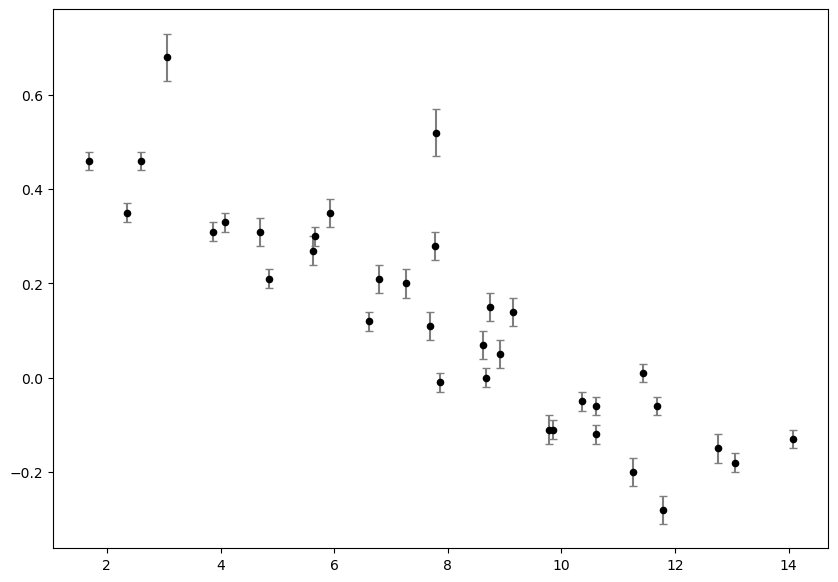

In [57]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

slope, intercept = mcFit(xdat, ydat, ydat_err)

# along with out fits
ax.plot(data['X'], linear(data['X'], *popt), label='raw')
ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='MC')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

ax.text(2, -0.2, "Slope: {:+5.3f} $\pm$ {:5.3f}".format(np.mean(slope), np.std(slope)), fontsize=18)
ax.text(2, -0.25, "Intercept: {:5.3f} $\pm$ {:5.3f}".format(np.mean(intercept), np.std(intercept)), fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

## Homework #10

**REMINDER:** *All coding assignment will be turned in as .ipynb files, to the same PHYS_X0223 repository on GitHub.*   
*They should be turned in with the following naming:*
    
    Lastname_Firstinitial_25_HW10.ipynb

### Problem 1:
We can't know the x data perfectly suppose the data have uniform x errors of 0.5 use the MC technique to estimate the slope *AND* the uncertainty taking into account these errors.



mean slope : -0.0617 , mean intercept: 0.6313


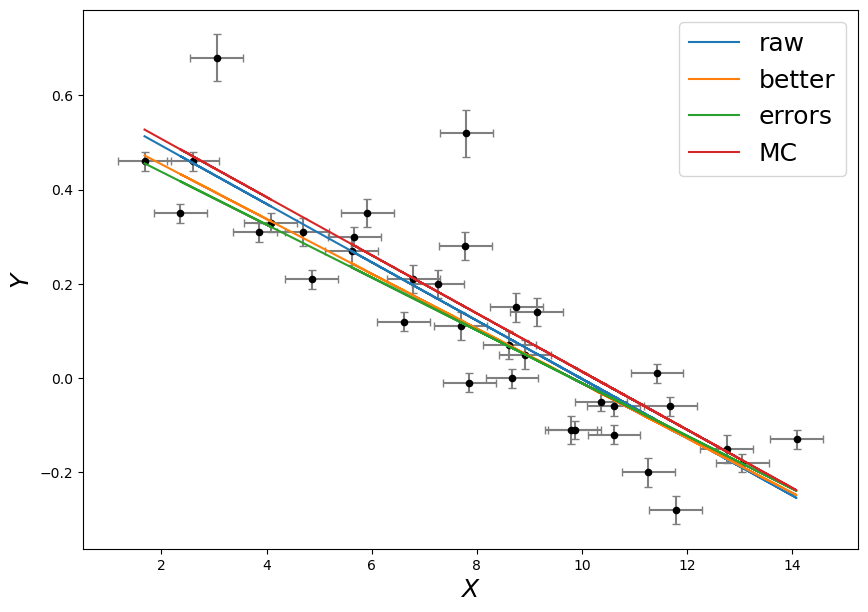

In [58]:

def mcFit(x , y, y_err):
    slopes = list()
    y_ints = list()
    iters = 500 
    for i in range(iters): 
        weights = np.random.randn(len(y))
        weights_2 = np.random.rand(len(x))

        y_adj = y + y_err*weights
        x_adj = x + 0.5*weights_2

        params, other = opt.curve_fit(linear , x_adj , y_adj)
        slopes.append(params[0])
        y_ints.append(params[1])
    return slopes , y_ints 

slope, intercept = mcFit(data['X'], data ['Y'] , data['Y_ERR']) 

print ('mean slope : {:6.4f} , mean intercept: {:6.4f}'.format(np.mean(slope),np.mean(intercept)))

popt_err, pcov = opt.curve_fit(linear, data['X'], data['Y'], sigma=data['Y_ERR'])


fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)
ax.errorbar(data['X'], data['Y'],xerr=0.5, c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with our fits
ax.plot(data['X'], linear(data['X'], *popt), label='raw')
ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='MC')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

        

    

### Problem 2:
Repeat problem #1 , but change the errors INCREASE as we move away from X = 8 (as they do) to be precise: suppose X_ERR = |x - 8| /10, e.g. it increases by .1 per unit.

Plot both slopes (Problem 1 & 2). How does the fit change? 

mean slope : -0.0613 , mean intercept: 0.6126


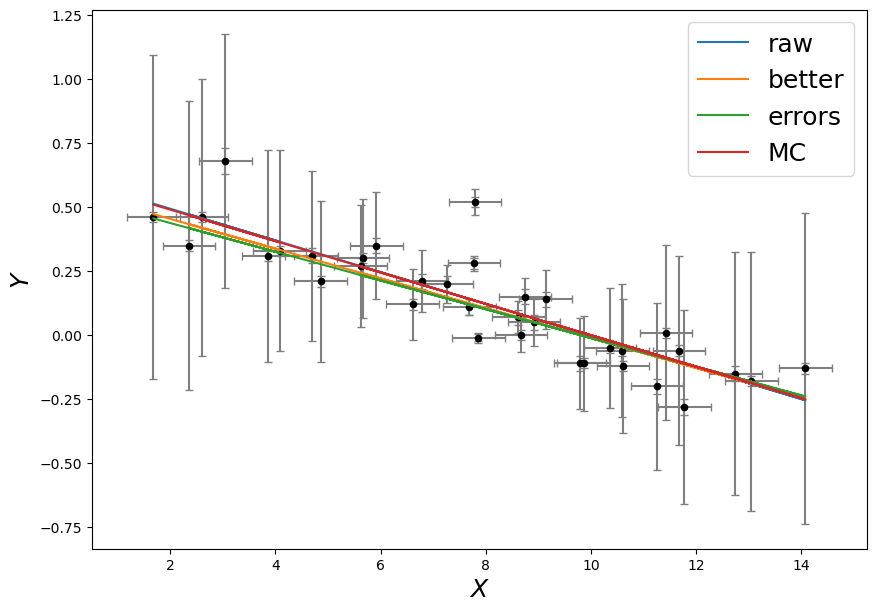

In [59]:
def mcFit(x , y, x_err,  y_err):
    slopes = list()
    y_ints = list()
    iters = 500 
    for i in range(iters): 
        weights = np.random.randn(len(y))
        weights_2 = np.random.randn(len(x))

        y_adj = y + y_err*weights
        x_adj = x + x_err*weights_2

        params, other = opt.curve_fit(linear , x_adj , y_adj)
        slopes.append(params[0])
        y_ints.append(params[1])
    return slopes , y_ints 
x_err = np.abs(data['X']-8)/10.0
slope, intercept = mcFit(data['X'], data ['Y'] , x_err, data['Y_ERR']) 

print ('mean slope : {:6.4f} , mean intercept: {:6.4f}'.format(np.mean(slope),np.mean(intercept)))

popt_err, pcov = opt.curve_fit(linear, data['X'], data['Y'], sigma=data['Y_ERR'])


fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)
ax.errorbar(data['X'], data['Y'],x_err,c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)
ax.errorbar(data['X'], data['Y'], xerr=0.5, c='tab:gray', fmt = '.' , markersize=1, capsize= 3 , zorder=0)

# along with our fits
ax.plot(data['X'], linear(data['X'], *popt), label='raw')
ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='MC')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()


### Problem 3: 
Repeat problem 1 & 2, but now anaylze for X vs. Z data, including both uniform 0.5 and X_ERR = |x - 8| /10 uncertainties.

Gaussian-type X_ERR = |x-8|/10:
  mean slope     : 0.0030
  mean intercept : -0.0246

Uniform X_ERR ±0.5:
  mean slope     : 0.0027
  mean intercept : -0.0217


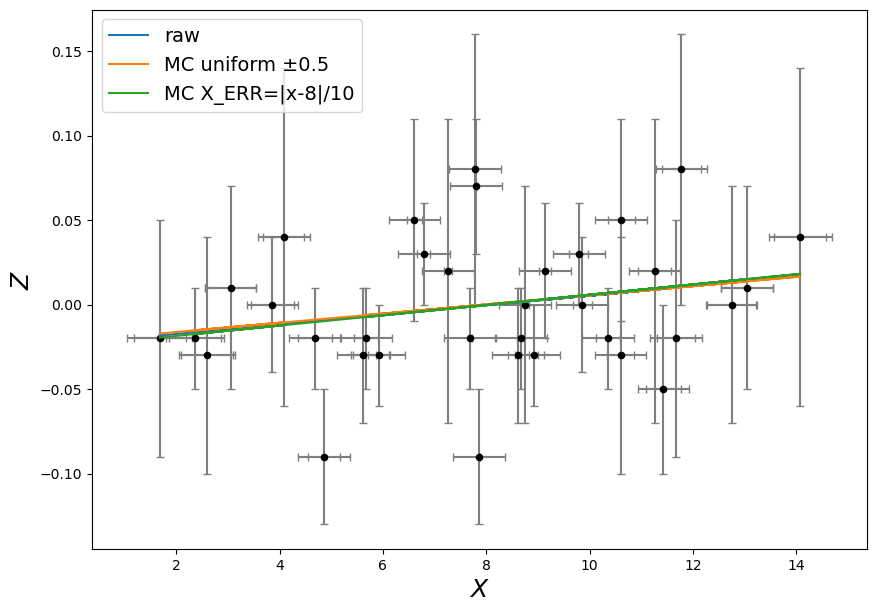

Z range: -0.09 0.08
Z_ERR min/med/max: 0.03 0.04 0.1


In [60]:
x_err_func = np.abs(data['X'] - 8) / 10.0

def mcFit(x, y, x_err, y_err):
    slopes = []
    y_ints = []
    iters = 500
    for i in range(iters): 
        weights = np.random.randn(len(y))
        weights_2 = np.random.randn(len(x))
        y_adj = y + y_err * weights
        x_adj = x + x_err * weights_2
        params, other = opt.curve_fit(linear, x_adj, y_adj)
        slopes.append(params[0])
        y_ints.append(params[1])
    return slopes, y_ints 

# ---- 1) X_ERR = |x - 8| / 10 ----
slope_func, intercept_func = mcFit(data['X'], data['Z'], x_err_func, data['Z_ERR'])

# ---- 2) Uniform ±0.5 X error ----
x_err_uniform = np.full_like(data['X'], 0.5)
slope_uniform, intercept_uniform = mcFit(data['X'], data['Z'], x_err_uniform, data['Z_ERR'])

print('Gaussian-type X_ERR = |x-8|/10:')
print('  mean slope     : {:6.4f}'.format(np.mean(slope_func)))
print('  mean intercept : {:6.4f}'.format(np.mean(intercept_func)))
print()
print('Uniform X_ERR ±0.5:')
print('  mean slope     : {:6.4f}'.format(np.mean(slope_uniform)))
print('  mean intercept : {:6.4f}'.format(np.mean(intercept_uniform)))

# ---- Plot ----
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Z'], s=20, c='black', zorder=2)
ax.errorbar(data['X'], data['Z'], yerr=data['Z_ERR'], c='tab:gray', fmt='.', markersize=1, capsize=3, zorder=0)
ax.errorbar(data['X'], data['Z'], xerr=x_err_func, c='tab:gray', fmt='.', markersize=1, capsize=3, zorder=0)
ax.errorbar(data['X'], data['Z'], xerr=0.5, c='tab:gray', fmt='.', markersize=1, capsize=3, zorder=0)

# reference fits
popt_Z, _ = opt.curve_fit(linear, data['X'], data['Z'])
ax.plot(data['X'], linear(data['X'], *popt_Z), label='raw')

ax.plot(data['X'], linear(data['X'], np.mean(slope_uniform), np.mean(intercept_uniform)), label='MC uniform ±0.5')
ax.plot(data['X'], linear(data['X'], np.mean(slope_func), np.mean(intercept_func)), label='MC X_ERR=|x-8|/10')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Z$', fontsize=18)
plt.legend(loc='best', fontsize=14)
plt.show()

print('Z range:', data['Z'].min(), data['Z'].max())
print('Z_ERR min/med/max:', data['Z_ERR'].min(), np.median(data['Z_ERR']), data['Z_ERR'].max())
